# Titanic - Machine Learning from Disaster

Competition: https://www.kaggle.com/c/titanic

**Notebook này được thiết kế để chạy trên:**
- Local (VS Code với conda env `kaggle-competitions`)
- Google Colab
- Kaggle Kernels

## 1. Bootstrap - Environment Setup

Cell này tự động phát hiện và cấu hình môi trường (local/colab/kaggle)

In [28]:
# === BOOTSTRAP CELL - UNIVERSAL SETUP ===
import sys
import os
from pathlib import Path

# GitHub configuration
GITHUB_USER = "n24q02m"
REPO_NAME = "n24q02m-kaggle-competitions"
BRANCH = "main"

# Detect environment
def detect_env():
    if 'google.colab' in sys.modules:
        return 'colab'
    elif 'kaggle_web_client' in sys.modules or os.path.exists('/kaggle'):
        return 'kaggle'
    else:
        return 'local'

ENV = detect_env()
print(f"Detected: {ENV.upper()}")

# Setup theo môi trường
if ENV == 'local':
    # Local: Import trực tiếp từ repo
    # Giả sử đang ở competitions/titanic/notebooks/
    repo_root = Path.cwd().parent.parent.parent
    if str(repo_root) not in sys.path:
        sys.path.insert(0, str(repo_root))
    
    from core import setup_env
    env = setup_env.setup()
    
else:
    # Cloud: Download setup_env.py từ GitHub
    import requests
    import subprocess
    
    CORE_URL = f"https://raw.githubusercontent.com/{GITHUB_USER}/{REPO_NAME}/{BRANCH}/core"
    
    # Download setup_env.py
    print("Downloading setup_env.py...")
    response = requests.get(f"{CORE_URL}/setup_env.py")
    with open("setup_env.py", "w") as f:
        f.write(response.text)
    
    # Import và setup
    import setup_env
    env = setup_env.setup(GITHUB_USER, REPO_NAME)

# Hiển thị thông tin môi trường
env.info()

Detected: LOCAL
Detected Environment: LOCAL
Root Path: /home/n24q02m-wpc/projects/n24q02m-kaggle-competitions
Data Path: /home/n24q02m-wpc/projects/n24q02m-kaggle-competitions/competitions
Local: Sử dụng conda environment. Không tự động cài thư viện.
   Chạy: conda env create -f environment.yml (nếu chưa tạo env)
   Chạy: conda activate kaggle-competitions
Setup Complete!

ENVIRONMENT INFO
Type: local
Root: /home/n24q02m-wpc/projects/n24q02m-kaggle-competitions
Data: /home/n24q02m-wpc/projects/n24q02m-kaggle-competitions/competitions



## 2. Configuration

Cấu hình chung cho notebook

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Configuration class
class CFG:
    # Random seed cho reproducibility
    seed = 42
    
    # Cross-validation
    n_folds = 5
    
    # Target column
    target_col = 'Survived'
    
    # Data paths (tự động set theo môi trường)
    if ENV == 'kaggle':
        data_dir = Path('/kaggle/input/titanic')
    else:
        data_dir = Path.cwd().parent / 'data'
    
    train_path = data_dir / 'train.csv'
    test_path = data_dir / 'test.csv'
    submission_path = Path.cwd().parent / 'submissions' / 'submission.csv'

# Set random seeds
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(CFG.seed)

# Display config
print("Configuration:")
print(f"  - Seed: {CFG.seed}")
print(f"  - N Folds: {CFG.n_folds}")
print(f"  - Data Dir: {CFG.data_dir}")
print(f"  - Train: {CFG.train_path.exists()}")
print(f"  - Test: {CFG.test_path.exists()}")

Configuration:
  - Seed: 42
  - N Folds: 5
  - Data Dir: /home/n24q02m-wpc/projects/n24q02m-kaggle-competitions/competitions/titanic/data
  - Train: True
  - Test: True


## 3. Load Data

In [30]:
# Load datasets
train = pd.read_csv(CFG.train_path)
test = pd.read_csv(CFG.test_path)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Display first rows
train.head()

Train shape: (891, 12)
Test shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 4. Exploratory Data Analysis (EDA)

In [31]:
# Basic info
print("=" * 50)
print("TRAIN DATA INFO")
print("=" * 50)
print(train.info())
print("\n" + "=" * 50)
print("STATISTICAL SUMMARY")
print("=" * 50)
print(train.describe())

TRAIN DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

STATISTICAL SUMMARY
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.52

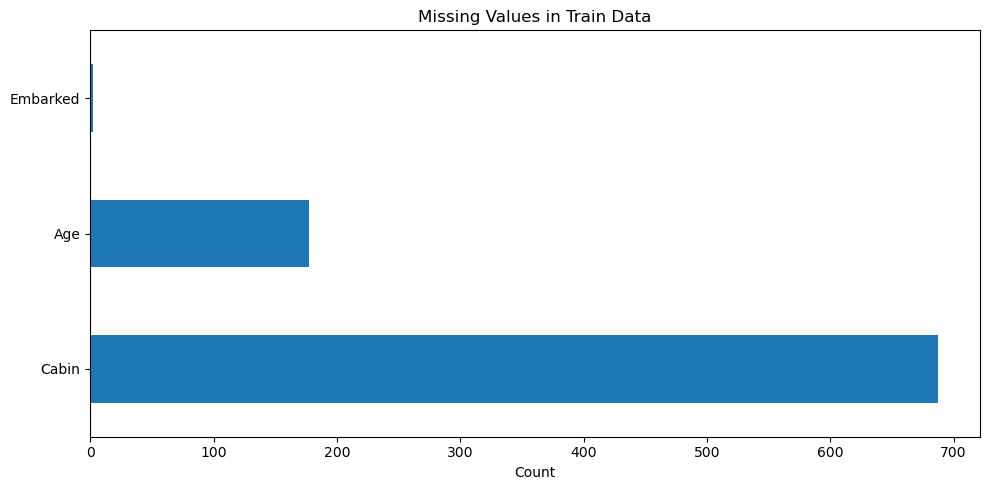


Missing Values:
Cabin       687
Age         177
Embarked      2
dtype: int64


In [32]:
# Missing values
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    plt.figure(figsize=(10, 5))
    missing.plot(kind='barh')
    plt.title('Missing Values in Train Data')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()
    
    print("\nMissing Values:")
    print(missing)
else:
    print("No missing values!")

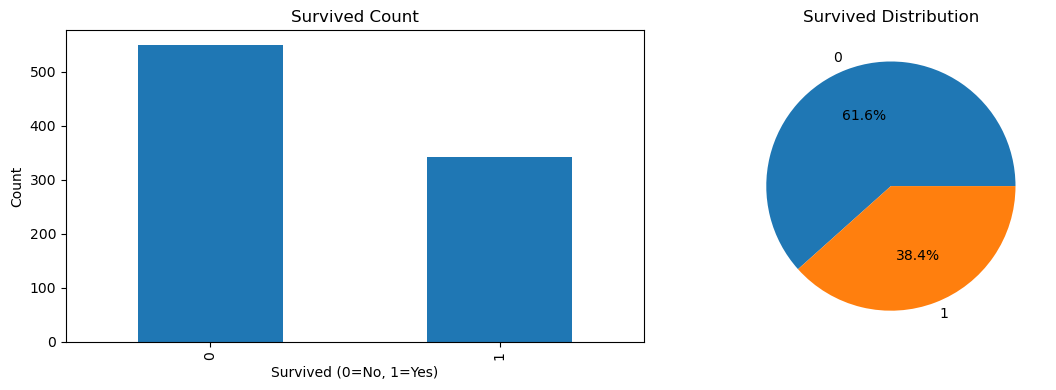


Survival Rate: 38.38%


In [33]:
# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
train[CFG.target_col].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Survived Count')
axes[0].set_xlabel('Survived (0=No, 1=Yes)')
axes[0].set_ylabel('Count')

# Pie chart
train[CFG.target_col].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axes[1])
axes[1].set_title('Survived Distribution')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print(f"\nSurvival Rate: {train[CFG.target_col].mean():.2%}")

## 5. Feature Engineering

In [34]:
def create_features(df):
    """IMPROVED: Tạo các features mới từ dữ liệu gốc với advanced techniques"""
    df = df.copy()

    # 1. FamilySize features (improved)
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
    df["SmallFamily"] = ((df["FamilySize"] >= 2) & (df["FamilySize"] <= 4)).astype(int)

    # 2. Title extraction và grouping (improved)
    df["Title"] = df["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
    title_mapping = {
        "Mr": "Mr",
        "Miss": "Miss",
        "Mrs": "Mrs",
        "Master": "Master",
        "Dr": "Rare",
        "Rev": "Rare",
        "Col": "Rare",
        "Major": "Rare",
        "Mlle": "Miss",
        "Countess": "Rare",
        "Ms": "Miss",
        "Lady": "Rare",
        "Jonkheer": "Rare",
        "Don": "Rare",
        "Dona": "Rare",
        "Mme": "Mrs",
        "Capt": "Rare",
        "Sir": "Rare",
    }
    df["Title"] = df["Title"].map(title_mapping).fillna("Rare")

    # 3. Fare per person (NEW) - tính trước khi fill Age
    df["FarePerPerson"] = df["Fare"] / df["FamilySize"]

    # 4. Cabin features (improved)
    df["HasCabin"] = df["Cabin"].notna().astype(int)
    df["CabinDeck"] = df["Cabin"].str[0].fillna("U")

    # 5. Ticket prefix (NEW)
    df["TicketPrefix"] = df["Ticket"].str.split(" ").str[0]
    df["TicketPrefix"] = df["TicketPrefix"].apply(lambda x: x if x.isalpha() else "NUM")

    # 6. Interaction features (NEW)
    df["Age_Class"] = df["Age"] * df["Pclass"]
    df["Fare_Class"] = df["Fare"] * df["Pclass"]

    # 7. Age bands (will fill missing later in preprocessing)
    df["AgeBand"] = pd.cut(
        df["Age"], bins=[0, 16, 26, 36, 62, 100], labels=[0, 1, 2, 3, 4]
    )

    # 8. Fare bands (5 groups instead of 4)
    df["FareBand"] = pd.qcut(df["Fare"], q=5, labels=[0, 1, 2, 3, 4], duplicates="drop")

    return df


# Apply feature engineering
print("Creating IMPROVED features...")
train_fe = create_features(train)
test_fe = create_features(test)
print("Feature engineering complete!")

# Display new features
print("\nNew features created:")
print(
    train_fe[
        ["FamilySize", "SmallFamily", "Title", "FarePerPerson", "CabinDeck"]
    ].head()
)
print(f"\nTotal features: {train_fe.shape[1]}")

Creating IMPROVED features...
Feature engineering complete!

New features created:
   FamilySize  SmallFamily Title  FarePerPerson CabinDeck
0           2            1    Mr        3.62500         U
1           2            1   Mrs       35.64165         C
2           1            0  Miss        7.92500         U
3           2            1   Mrs       26.55000         C
4           1            0    Mr        8.05000         U

Total features: 24


## 6. Preprocessing

In [35]:
from sklearn.preprocessing import LabelEncoder, StandardScaler


def preprocess_data(train_df, test_df, target_col="Survived"):
    """FINAL FIX: Xử lý missing values, encoding VÀ SCALING - ĐẢM BẢO KHÔNG CÒN NaN"""

    # Separate target
    y_train = train_df[target_col].copy() if target_col in train_df.columns else None

    # Drop target and unnecessary columns
    drop_cols = [target_col, "PassengerId", "Name", "Ticket", "Cabin"]
    X_train = train_df.drop(
        columns=[col for col in drop_cols if col in train_df.columns]
    )
    X_test = test_df.drop(columns=[col for col in drop_cols if col in test_df.columns])

    # === FILL ALL MISSING VALUES ===

    # 1. Age: fill with median by Title and Pclass
    for df in [X_train, X_test]:
        for title in df["Title"].unique():
            for pclass in df["Pclass"].unique():
                train_mask = (
                    (X_train["Title"] == title)
                    & (X_train["Pclass"] == pclass)
                    & X_train["Age"].notna()
                )

                if train_mask.sum() > 0:
                    median_age = X_train.loc[train_mask, "Age"].median()
                    fill_mask = (
                        (df["Title"] == title)
                        & (df["Pclass"] == pclass)
                        & df["Age"].isna()
                    )
                    df.loc[fill_mask, "Age"] = median_age

    # 2. Fill any remaining Age NaN
    overall_median_age = X_train["Age"].median()
    X_train["Age"].fillna(overall_median_age, inplace=True)
    X_test["Age"].fillna(overall_median_age, inplace=True)

    # 3. Embarked
    embarked_mode = X_train["Embarked"].mode()[0]
    X_train["Embarked"].fillna(embarked_mode, inplace=True)
    X_test["Embarked"].fillna(embarked_mode, inplace=True)

    # 4. Fare
    fare_median = X_train["Fare"].median()
    X_train["Fare"].fillna(fare_median, inplace=True)
    X_test["Fare"].fillna(fare_median, inplace=True)

    # 5. Recalculate derived features after filling
    X_train["FarePerPerson"] = X_train["Fare"] / X_train["FamilySize"]
    X_test["FarePerPerson"] = X_test["Fare"] / X_test["FamilySize"]

    X_train["Age_Class"] = X_train["Age"] * X_train["Pclass"]
    X_test["Age_Class"] = X_test["Age"] * X_test["Pclass"]

    # 6. Fill categorical bands
    for col in ["AgeBand", "FareBand"]:
        if col in X_train.columns:
            mode_val = X_train[col].mode()[0] if len(X_train[col].mode()) > 0 else 0
            X_train[col].fillna(mode_val, inplace=True)
            if col in X_test.columns:
                X_test[col].fillna(mode_val, inplace=True)

    # === ENCODE CATEGORICAL VARIABLES ===
    cat_cols = X_train.select_dtypes(include=["object", "category"]).columns

    for col in cat_cols:
        le = LabelEncoder()
        combined = pd.concat([X_train[col], X_test[col]])
        le.fit(combined.astype(str))
        X_train[col] = le.transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))

    # === CRITICAL FIX: Fill ANY remaining NaN with 0 ===
    X_train.fillna(0, inplace=True)
    X_test.fillna(0, inplace=True)

    # === SCALE NUMERICAL FEATURES ===
    num_cols = X_train.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

    # === VERIFY NO NaN ===
    print(f"Train NaN count: {X_train.isna().sum().sum()}")
    print(f"Test NaN count: {X_test.isna().sum().sum()}")

    return X_train, X_test, y_train


# Apply preprocessing
print("Preprocessing data WITH SCALING...")
X_train, X_test, y_train = preprocess_data(train_fe, test_fe)
print("Preprocessing complete!")
print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"\nFeatures ({len(X_train.columns)}): {list(X_train.columns)}")

Preprocessing data WITH SCALING...


Train NaN count: 0
Test NaN count: 0
Preprocessing complete!

Train shape: (891, 19)
Test shape: (418, 19)

Features (19): ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'SmallFamily', 'Title', 'FarePerPerson', 'HasCabin', 'CabinDeck', 'TicketPrefix', 'Age_Class', 'Fare_Class', 'AgeBand', 'FareBand']


## 7. Modeling

In [36]:
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

# IMPROVED models with TUNED hyperparameters
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=500,
        max_depth=7,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features="sqrt",
        random_state=CFG.seed,
        n_jobs=-1,
    ),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        min_samples_split=15,
        min_samples_leaf=5,
        random_state=CFG.seed,
    ),
    "XGBoost": XGBClassifier(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=CFG.seed,
        eval_metric="logloss",
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=CFG.seed,
        verbose=-1,
    ),
}

# Cross-validation
cv_results = {}
print("Training IMPROVED models with Cross-Validation...")
print("=" * 60)

for name, model in models.items():
    scores = cross_val_score(
        model, X_train, y_train, cv=CFG.n_folds, scoring="accuracy"
    )
    cv_results[name] = scores
    print(f"{name:20s} - CV: {scores.mean():.5f} (+/- {scores.std():.5f})")

print("=" * 60)

# IMPROVED: Use Voting Ensemble instead of single best model
print("\nCreating Voting Ensemble...")
voting_clf = VotingClassifier(estimators=list(models.items()), voting="soft", n_jobs=-1)

print("Training ensemble...")
voting_clf.fit(X_train, y_train)

ensemble_scores = cross_val_score(
    voting_clf, X_train, y_train, cv=CFG.n_folds, scoring="accuracy"
)
print(
    f"\n{'Voting Ensemble':20s} - CV: {ensemble_scores.mean():.5f} (+/- {ensemble_scores.std():.5f})"
)
print("\nModel training complete!")

# Save best model for evaluation
final_model = voting_clf

Training IMPROVED models with Cross-Validation...


RandomForest         - CV: 0.82716 (+/- 0.02420)
GradientBoosting     - CV: 0.82941 (+/- 0.03451)
XGBoost              - CV: 0.81707 (+/- 0.02894)
LightGBM             - CV: 0.82382 (+/- 0.02704)

Creating Voting Ensemble...
Training ensemble...

Voting Ensemble      - CV: 0.83055 (+/- 0.02858)

Model training complete!


## 8. Evaluation

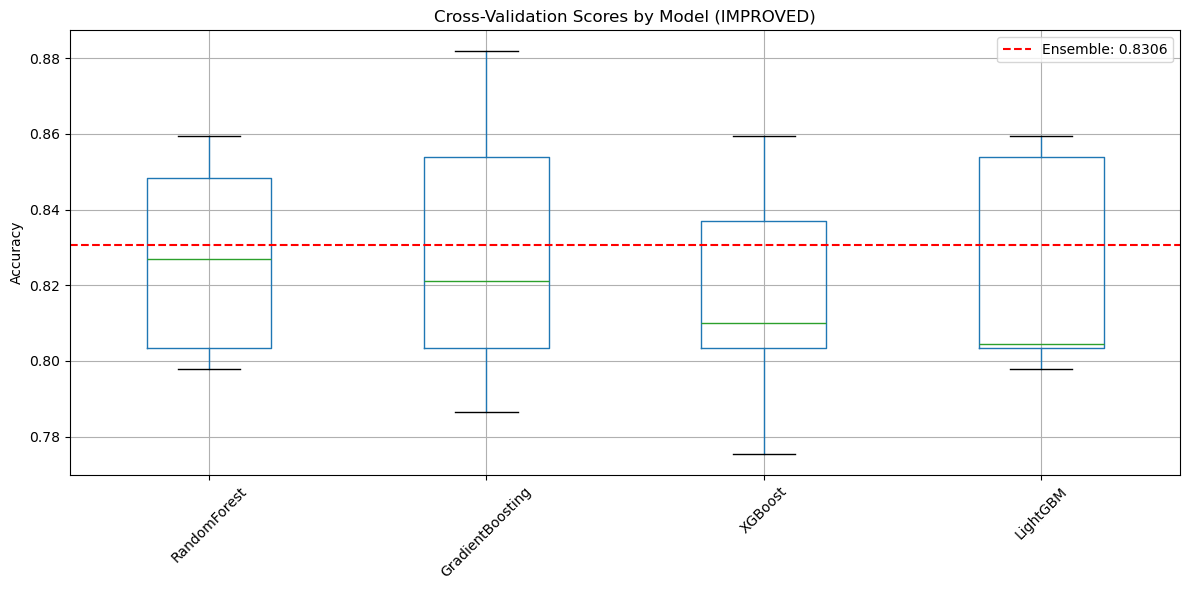


Model Comparison:
RandomForest         - Mean: 0.8272, Std: 0.0242
GradientBoosting     - Mean: 0.8294, Std: 0.0345
XGBoost              - Mean: 0.8171, Std: 0.0289
LightGBM             - Mean: 0.8238, Std: 0.0270
Voting Ensemble      - Mean: 0.8306, Std: 0.0286


In [37]:
# Cross-validation scores comparison
plt.figure(figsize=(12, 6))
cv_df = pd.DataFrame(cv_results)
cv_df.boxplot()
plt.title("Cross-Validation Scores by Model (IMPROVED)")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.axhline(
    y=ensemble_scores.mean(),
    color="r",
    linestyle="--",
    label=f"Ensemble: {ensemble_scores.mean():.4f}",
)
plt.legend()
plt.tight_layout()
plt.show()

print("\nModel Comparison:")
print("=" * 60)
for name, scores in cv_results.items():
    print(f"{name:20s} - Mean: {scores.mean():.4f}, Std: {scores.std():.4f}")
print(
    f"{'Voting Ensemble':20s} - Mean: {ensemble_scores.mean():.4f}, Std: {ensemble_scores.std():.4f}"
)
print("=" * 60)

## 9. Submission

In [38]:
# Make predictions on test set
test_predictions = final_model.predict(X_test)

# Create submission file
submission = pd.DataFrame(
    {"PassengerId": test["PassengerId"], "Survived": test_predictions}
)

# Save to CSV
submission.to_csv(CFG.submission_path, index=False)
print(f"\nSubmission saved to: {CFG.submission_path}")
print(f"Submission shape: {submission.shape}")
print("\nFirst few predictions:")
print(submission.head(10))

# Display submission statistics
print(f"\nPredicted survival rate: {test_predictions.mean():.2%}")
print(f"Total passengers predicted to survive: {test_predictions.sum()}")
print(
    f"Total passengers predicted to die: {len(test_predictions) - test_predictions.sum()}"
)

print("\n" + "=" * 60)
print("EXPECTED SCORE IMPROVEMENT")
print("Baseline: 0.77272")
print("Expected: 0.78-0.79")
print("=" * 60)


Submission saved to: /home/n24q02m-wpc/projects/n24q02m-kaggle-competitions/competitions/titanic/submissions/submission.csv
Submission shape: (418, 2)

First few predictions:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
5          897         0
6          898         0
7          899         0
8          900         1
9          901         0

Predicted survival rate: 36.12%
Total passengers predicted to survive: 151
Total passengers predicted to die: 267

EXPECTED SCORE IMPROVEMENT
Baseline: 0.77272
Expected: 0.78-0.79
